<a href="https://colab.research.google.com/github/Geringer13/Netology_pyda/blob/master/ML_Time_Series2_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data = pd.read_csv('international-airline-passengers.csv')['Count']

In [0]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [0]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Не стационарный вариант

In [0]:
data_ns = data

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


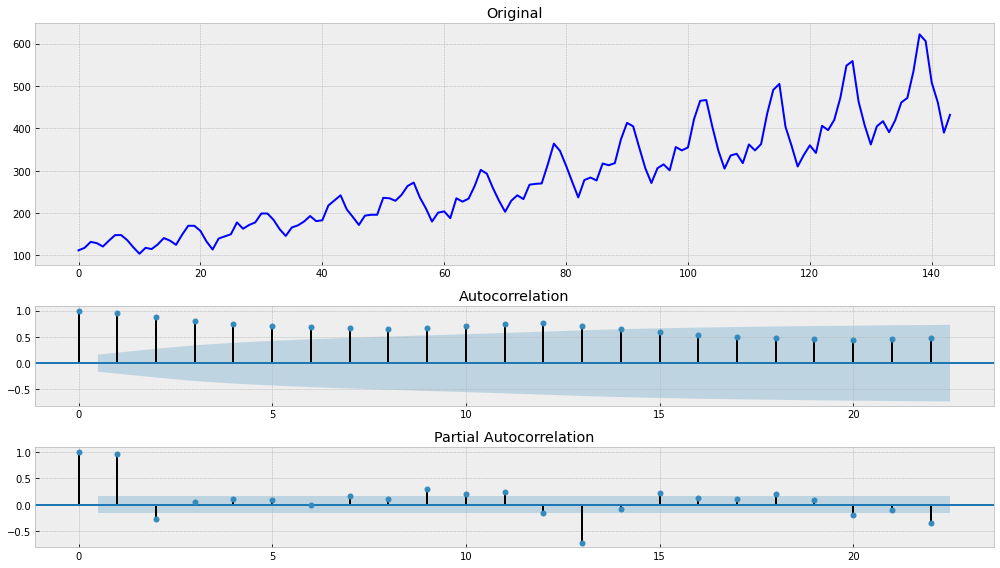

In [53]:
tsplot(data_ns)

Сделаем стационарный вариант, для дальнейшего сравнения

In [0]:
data = boxcox(data, 0)

In [0]:
data = data[1:] - data[:-1]

In [0]:
data = data[12:] - data[:-12]

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


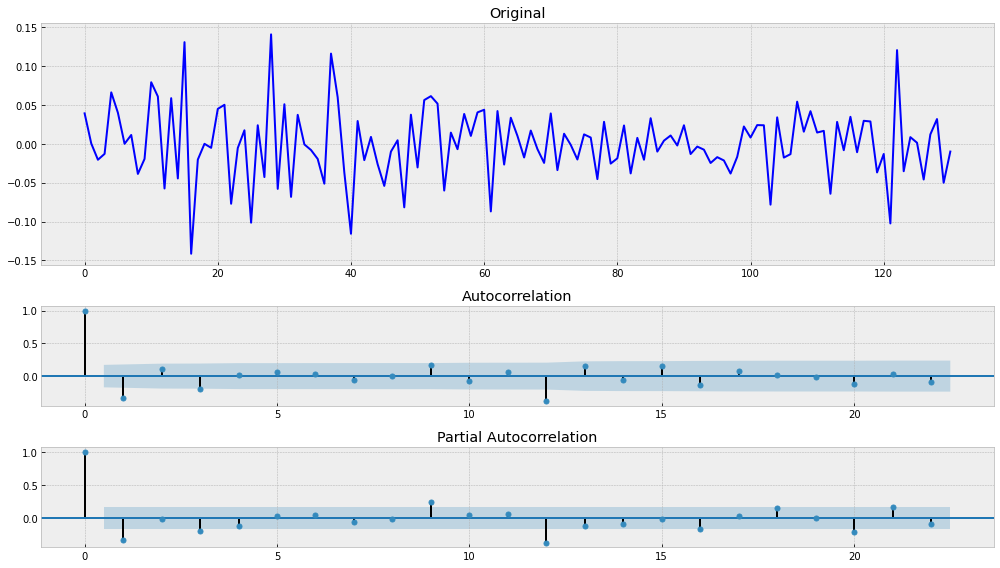

In [64]:
tsplot(data)

Проведём сравнение через МА

In [0]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [0]:
ser_ns = moving_average(data_ns, 7)

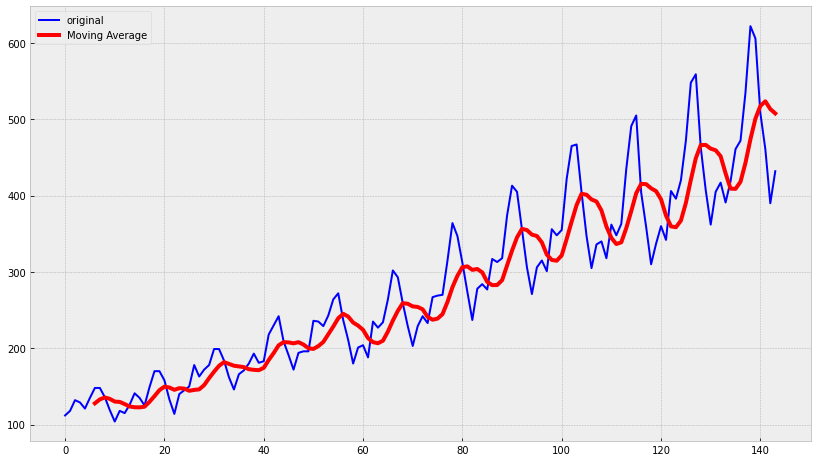

In [66]:
ser_ns = moving_average(data_ns, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(data_ns, color='blue',label='original')
    plt.plot(ser_ns, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [0]:
ser_s = moving_average(data, 7)

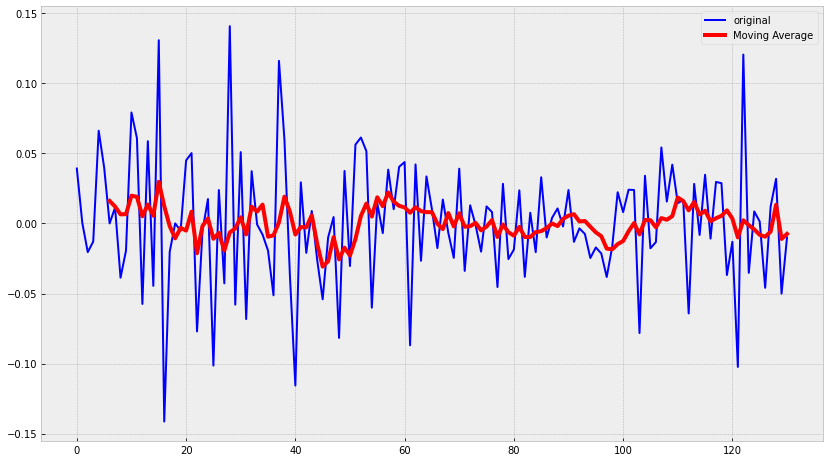

In [65]:
ser_s = moving_average(data, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(data, color='blue',label='original')
    plt.plot(ser_s, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Предскажем 5 следующих значений

In [0]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

Не стационарный

In [0]:
series_pred_ns = predict(data_ns, 7, 50)

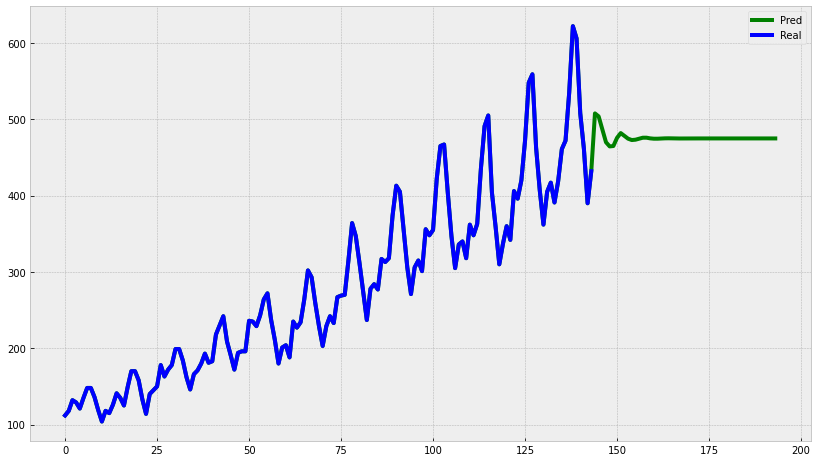

In [69]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred_ns, color='green', linewidth='4', label='Pred')
    plt.plot(data_ns, color='blue', linewidth='4', label='Real')
    plt.legend()

Стационарный

In [0]:
data = pd.DataFrame(data)

In [0]:
series_pred_s = predict(data, 7, 50)

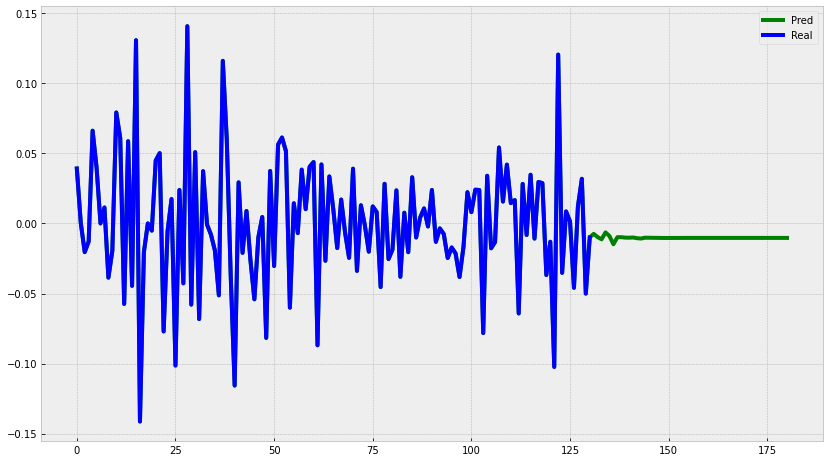

In [78]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred_s, color='green', linewidth='4', label='Pred')
    plt.plot(data, color='blue', linewidth='4', label='Real')
    plt.legend()